In [243]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import datetime as dt
from linearmodels.iv import IV2SLS

%matplotlib inline

## Import Data

In [244]:
price_df       = pd.read_csv('../data/electricity/elc_retail_price_monthly.csv', na_values = 'NM')
sales_df       = pd.read_csv('../data/electricity/elc_retail_sales_monthly.csv', na_values = 'NM')
fossil_cost_df = pd.read_csv('../data/fossil/avg_cost_fossil.csv', na_values = ['W', '--', 'NM'])
pcepi_df       = pd.read_csv('../data/inflation/us_pcepi.csv')
ddd_df        = pd.read_csv('../data/temperature/state_monthly_hdd_cdd.csv')

## Clean Data

In [245]:
# Fix state names
sales_df['State']       = sales_df['State'].apply(lambda x: x.strip().lower()) 
price_df['State']       = price_df['State'].apply(lambda x: x.strip().lower()) 
fossil_cost_df['state'] = fossil_cost_df['state'].apply(lambda x: x.strip().lower()) 

# Fix dates
pcepi_df['month'] = pcepi_df['DATE'].apply(lambda x: x[:1])
pcepi_df['year']  = pcepi_df['DATE'].apply(lambda x: x[-4:])
ddd_df['month']   = ddd_df['month'].astype(str)
ddd_df['year']    = ddd_df['year'].astype(str)


# Reshape dataframes
sales_melt_df  = pd.melt(sales_df, id_vars = ['State'], value_vars = sales_df.columns[1:],
       var_name = 'date', value_name = 'load')


price_melt_df  = pd.melt(price_df, id_vars = ['State'], value_vars = price_df.columns[1:],
       var_name = 'date', value_name = 'price')


fossil_cost_df = pd.melt(fossil_cost_df, id_vars = ['state', 'fuel'], value_vars = fossil_cost_df.columns[4:],
       var_name = 'date', value_name = 'cost').reset_index(drop = True)
fossil_cost_df['cost'] = fossil_cost_df['cost'].fillna(-1234)
fossil_cost_df = fossil_cost_df.groupby(['state', 'date', 'fuel'])['cost'].sum().unstack('fuel').reset_index()
fossil_cost_df.columns = (list(fossil_cost_df.columns[:2]) + 
                          [x.strip().replace(' ', '_') + '_cost' for x in fossil_cost_df.columns[2:]])

In [246]:
data_df = price_melt_df.merge(sales_melt_df, on = ['State', 'date']).rename(columns = {'State': 'state'}).merge(
            fossil_cost_df, on = ['state', 'date'])

# Month abbreviations
month_abrv_dict = dict(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                          range(1,13)))

# Clean up columns
data_df['state'] = data_df['state'].apply(lambda x: x.strip().lower()) 
data_df['month'] = data_df['date'].apply(lambda x: str(month_abrv_dict.get(x.split('-')[0])))
data_df['year']  = data_df['date'].apply(lambda x: str(2000+int(x.split('-')[1])))
data_df['price'] = pd.to_numeric(data_df['price'])/100
data_df['load']  = pd.to_numeric(data_df['load'])

# Merge with pcepi and ddd data
data_df = data_df.merge(pcepi_df, on =['month', 'year']).drop('DATE', axis = 1).merge(
                        ddd_df, on = ['state', 'month', 'year'])

# Fix entries in fuel cost
fuel_cost_cols = [x for x in data_df.columns if 'cost' in x]
for fuel_cost_col in fuel_cost_cols:
    data_df[fuel_cost_col] = pd.to_numeric(fossil_cost_df[fuel_cost_col]).apply(
        lambda x: np.nan if (x == -1234 or x == 0) else x)
    
# Adjust for inflation
for price_col in (fuel_cost_cols + ['price']):
    data_df[price_col] = data_df[price_col]*100/data_df['PCEPI']
    
# Fix date columns
data_df['month'] = data_df['month'].astype(int) 
data_df['year']  = data_df['year'].astype(int)  

In [247]:
data_df.head()

,state,date,price,load,coal_cost,natural_gas_cost,petroleum_coke_cost,petroleum_liquids_cost,month,year,PCEPI,CDD,HDD
0,connecticut,Jan-11,0.186104,1372.0,NaN,NaN,NaN,NaN,1,2011,96.774,0.0,1273.0
1,connecticut,Jan-11,0.182463,1372.0,NaN,NaN,NaN,NaN,1,2011,98.705,0.0,1273.0
2,connecticut,Jan-11,0.182088,1372.0,NaN,NaN,NaN,NaN,1,2011,98.908,0.0,1273.0
3,connecticut,Jan-11,0.181984,1372.0,59.566513,4.779467,NaN,129.490224,1,2011,98.965,0.0,1273.0
4,maine,Jan-11,0.162440,441.0,NaN,2.314671,NaN,NaN,1,2011,96.774,0.0,1431.0


## Construct Reg Data

In [248]:
def drop_outliers(df, columns, frac = 0.05):
    
    df = df.copy()
    
    # Mark outliers for each column
    for column in columns:
        cut_low, cut_high = df[column].quantile([frac/2, (1-frac/2)])
        df[column + '_keep'] = ((df[column] < cut_high) & (df[column] > cut_low)).astype(int)
        
    # Subset to observations that aren't outliers for any column
    query_str = ' & '.join([x + '_keep == 1' for x in columns])
    
    return df.query(query_str).drop([x + '_keep' for x in columns], axis = 1).copy()

def df_drop_na(df, cols):
    
    return df[~df[cols].isna().any(axis=1)]

In [256]:
samples = int(2e6)

# Subset dataframe for relevant variables
em_sample_df = data_df[['state', 'price', 'load', 'month', 'year', 'coal_cost', 'CDD', 'HDD']].copy()

# Drop missing and outliers (CDD and HDD data already cleaned)
em_sample_df[~em_sample_df.isna().any(axis = 1)]
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load', 'coal_cost'], frac = 0.01)

print('Preliminary Data Set Observations:  ', len(em_sample_df))

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()

# Add reg data columns
em_concat_df['ln_load_rel']    = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel']   = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))
em_concat_df['ln_coal_rel']   = np.log(np.divide(em_concat_df['coal_cost_1'], em_concat_df['coal_cost_2']))

# Regressions should be done with pairs of data for the same state
reg_data_df = (em_concat_df.query('state_1 == state_2 & month_1 != month_2')
               .drop_duplicates().reset_index(drop = True).copy())
reg_data_df['time_diff'] = reg_data_df.apply(lambda x: dt.datetime(x.year_1, x.month_1, 1) - dt.datetime(x.year_2, x.month_2, 1), 
                                             axis = 1).apply(lambda x: np.round(x.days/30.4, 0))

reg_data_df = reg_data_df.sample(n=5000)
print('Regression Data Set Observations:  ', len(reg_data_df))

Preliminary Data Set Observations:   826
Regression Data Set Observations:   5000


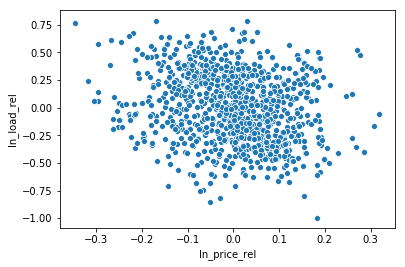

In [257]:
sns.scatterplot(x = 'ln_price_rel', y = 'ln_load_rel', data = reg_data_df.sample(n=1000))

## Estimation

### OLS

In [258]:
smf.ols('ln_load_rel~ ln_price_rel', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     364.9
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           1.41e-78
Time:                        18:13:12   Log-Likelihood:                -1039.4
No. Observations:                5000   AIC:                             2083.
Df Residuals:                    4998   BIC:                             2096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0002      0.004     -0.040      0.968      -0.008       0.008
ln_price_rel    -0.7289      0.038    -19.103      0.000      -0.804      -0.654
==============================================================================
Omnibus:                       84.683   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.253
Skew:                          -0.026   Prob(JB):                     3.33e-11
Kurtosis:                       2.522   Cond. No.                         9.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [259]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     7.832
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           3.81e-50
Time:                        18:13:13   Log-Likelihood:                -1032.7
No. Observations:                5000   AIC:                             2163.
Df Residuals:                    4951   BIC:                             2483.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0129      0.028     -0.465      0.642      -0.067       0.041
C(state_1)[T.arizona]         1.286e+10   1.04e+11      0.124      0.902   -1.91e+11    2.17e+11
C(state_1)[T.arkansas]       -7.191e+11   1.44e+12     -0.498      0.618   -3.55e+12    2.11e+12
C(state_1)[T.california]     -3.955e+10   9.41e+10     -0.421      0.674   -2.24e+11    1.45e+11
C(state_1)[T.colorado]        4.526e+08   1.22e+11      0.004      0.997   -2.38e+11    2.39e+11
C(state_1)[T.connecticut]    -4.868e+10    1.5e+11     -0.324      0.746   -3.43e+11    2.46e+11
C(state_1)[T.delaware]       -2.373e+11   2.53e+11     -0.937      0.349   -7.34e+11    2.59e+11
C(state_1)[T.florida]        -8.849e+11   1.48e+12     -0.597      0.551   -3.79e+12    2.02e+12
C(state_1)[T.georgia]        -1.566e+11    2.3e+12     -0.068      0.946   -4.67e+12    4.36e+12
C(state_1)[T.idaho]          -2.174e+10   2.71e+10     -0.801      0.423   -7.49e+10    3.14e+10
C(state_1)[T.illinois]        1.913e+10   5.16e+10      0.371      0.711   -8.21e+10     1.2e+11
C(state_1)[T.indiana]         2.848e+11   1.67e+12      0.170      0.865      -3e+12    3.57e+12
C(state_1)[T.iowa]           -4.265e+11   1.59e+12     -0.268      0.789   -3.55e+12    2.69e+12
C(state_1)[T.kansas]         -3.129e+11    2.3e+12     -0.136      0.892   -4.83e+12     4.2e+12
C(state_1)[T.kentucky]        8.836e+11   1.26e+12      0.701      0.483   -1.59e+12    3.35e+12
C(state_1)[T.louisiana]      -9.882e+10    3.3e+11     -0.300      0.764   -7.45e+11    5.48e+11
C(state_1)[T.maine]           1.355e+10   6.82e+10      0.199      0.843    -1.2e+11    1.47e+11
C(state_1)[T.maryland]        4.671e+12   2.16e+12      2.161      0.031    4.33e+11    8.91e+12
C(state_1)[T.massachusetts]   8.919e+10   2.35e+11      0.379      0.704   -3.72e+11     5.5e+11
C(state_1)[T.michigan]        3.812e+09   1.78e+11      0.021      0.983   -3.44e+11    3.52e+11
C(state_1)[T.minnesota]      -2.771e+11   2.13e+12     -0.130      0.896   -4.45e+12     3.9e+12
C(state_1)[T.mississippi]     3.186e+09   1.16e+11      0.027      0.978   -2.25e+11    2.31e+11
C(state_1)[T.missouri]        1.073e+12    2.7e+12      0.397      0.691   -4.22e+12    6.37e+12
C(state_1)[T.montana]        -2.118e+10   4.76e+10     -0.445      0.656   -1.14e+11    7.21e+10
C(state_1)[T.nebraska]       -1.561e+09   1.05e+11     -0.015      0.988   -2.08e+11    2.05e+11
C(state_1)[T.nevada]          2.026e+12    1.9e+12      1.068      0.286   -1.69e+12    5.75e+12
C(state_1)[T.new hampshire]  -9.772e+10   2.25e+11     -0.434      0.664   -5.39e+11    3.43e+11
C(state_1)[T.new jersey]      4.743e+11   1.17e+12      0.405      0.686   -1.82e+12    2.77e+12
C(state_1)[T.new mexico]      8.814e+09   2.12e+11      0.042      0.967   -

In [260]:
smf.ols('ln_load_rel~ ln_price_rel + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     341.2
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:13:13   Log-Likelihood:                 714.57
No. Observations:                5000   AIC:                            -1393.
Df Residuals:                    4982   BIC:                            -1276.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0004      0.009      0.046      0.963      -0.017       0.018
C(month_1)[T.2]    -0.1788      0.011    -16.661      0.000      -0.200      -0.158
C(month_1)[T.3]    -0.2551      0.014    -18.782      0.000      -0.282      -0.228
C(month_1)[T.4]    -0.3926      0.013    -29.257      0.000      -0.419      -0.366
C(month_1)[T.5]    -0.3868      0.015    -25.947      0.000      -0.416      -0.358
C(month_1)[T.6]    -0.1688      0.013    -13.050      0.000      -0.194      -0.143
C(month_1)[T.7]     0.0182      0.012      1.487      0.137      -0.006       0.042
C(month_1)[T.8]    -0.0039      0.013     -0.306      0.760      -0.029       0.021
C(month_1)[T.9]    -0.1948      0.012    -15.953      0.000      -0.219      -0.171
C(month_2)[T.2]     0.1839      0.011     16.848      0.000       0.162       0.205
C(month_2)[T.3]     0.2697      0.013     20.192      0.000       0.244       0.296
C(month_2)[T.4]     0.3917      0.014     28.286      0.000       0.365       0.419
C(month_2)[T.5]     0.3793      0.015     25.946      0.000       0.351       0.408
C(month_2)[T.6]     0.1754      0.013     13.217      0.000       0.149       0.201
C(month_2)[T.7]    -0.0159      0.012     -1.309      0.190      -0.040       0.008
C(month_2)[T.8]     0.0014      0.013      0.114      0.909      -0.023       0.026
C(month_2)[T.9]     0.1945      0.012     15.947      0.000       0.171       0.218
ln_price_rel       -0.3579      0.036     -9.987      0.000      -0.428      -0.288
==============================================================================
Omnibus:                      151.772   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.908
Skew:                          -0.014   Prob(JB):                     8.79e-88
Kurtosis:                       4.387   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     90.36
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:13:14   Log-Likelihood:                 723.36
No. Observations:                5000   AIC:                            -1317.
Df Residuals:                    4935   BIC:                            -893.1
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0138      0.021     -0.649      0.516      -0.056       0.028
C(state_1)[T.arizona]        -2.556e+10   5.87e+10     -0.435      0.663   -1.41e+11    8.95e+10
C(state_1)[T.arkansas]       -7.889e+11   9.74e+11     -0.810      0.418    -2.7e+12    1.12e+12
C(state_1)[T.california]      1.079e+10   3.21e+10      0.337      0.736    -5.2e+10    7.36e+10
C(state_1)[T.colorado]        1.143e+09   1.68e+10      0.068      0.946   -3.17e+10     3.4e+10
C(state_1)[T.connecticut]    -1.082e+10   9.58e+10     -0.113      0.910   -1.99e+11    1.77e+11
C(state_1)[T.delaware]        4.987e+09   1.06e+11      0.047      0.963   -2.04e+11    2.13e+11
C(state_1)[T.florida]         3.583e+11   1.14e+12      0.316      0.752   -1.87e+12    2.58e+12
C(state_1)[T.georgia]        -2.132e+12   1.68e+12     -1.272      0.204   -5.42e+12    1.15e+12
C(state_1)[T.idaho]          -3.189e+09   1.35e+11     -0.024      0.981   -2.67e+11    2.61e+11
C(state_1)[T.illinois]        -1.08e+09    3.1e+10     -0.035      0.972   -6.19e+10    5.97e+10
C(state_1)[T.indiana]         7.089e+11   1.31e+12      0.542      0.587   -1.85e+12    3.27e+12
C(state_1)[T.iowa]            1.743e+12   1.18e+12      1.483      0.138   -5.61e+11    4.05e+12
C(state_1)[T.kansas]          1.406e+12   1.65e+12      0.853      0.394   -1.83e+12    4.64e+12
C(state_1)[T.kentucky]        4.089e+11   9.51e+11      0.430      0.667   -1.46e+12    2.27e+12
C(state_1)[T.louisiana]      -1.439e+10   2.46e+11     -0.058      0.953   -4.97e+11    4.68e+11
C(state_1)[T.maine]           3.735e+09   5.59e+10      0.067      0.947   -1.06e+11    1.13e+11
C(state_1)[T.maryland]        1.163e+12   1.45e+12      0.801      0.423   -1.68e+12    4.01e+12
C(state_1)[T.massachusetts]  -1.368e+10   1.48e+11     -0.092      0.926   -3.04e+11    2.77e+11
C(state_1)[T.michigan]       -6.096e+10   7.89e+10     -0.773      0.440   -2.16e+11    9.37e+10
C(state_1)[T.minnesota]      -8.018e+11   1.67e+12     -0.479      0.632   -4.08e+12    2.48e+12
C(state_1)[T.mississippi]    -6.178e+08   7.28e+10     -0.008      0.993   -1.43e+11    1.42e+11
C(state_1)[T.missouri]       -4.999e+11   1.54e+12     -0.324      0.746   -3.52e+12    2.52e+12
C(state_1)[T.montana]         5.716e+09    7.5e+10      0.076      0.939   -1.41e+11    1.53e+11
C(state_1)[T.nebraska]        4.381e+09   9.07e+10      0.048      0.961   -1.73e+11    1.82e+11
C(state_1)[T.nevada]          2.171e+12   1.32e+12      1.650      0.099   -4.09e+11    4.75e+12
C(state_1)[T.new hampshire]   8.012e+10   2.13e+11      0.376      0.707   -3.38e+11    4.98e+11
C(state_1)[T.new jersey]      8.202e+10   9.96e+11      0.082      0.934   -1.87e+12    2.04e+12
C(state_1)[T.new mexico]      1.277e+11   1.62e+11      0.788      0.431    

In [262]:
smf.ols('ln_load_rel~ ln_price_rel + C(state_1) + C(state_2) + C(month_1) + C(month_2) + time_diff', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     90.27
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:13:14   Log-Likelihood:                 743.19
No. Observations:                5000   AIC:                            -1354.
Df Residuals:                    4934   BIC:                            -924.2
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0142      0.021     -0.668      0.504      -0.056       0.027
C(state_1)[T.arizona]            0.0237      0.014      1.706      0.088      -0.004       0.051
C(state_1)[T.arkansas]           0.0043      0.014      0.308      0.758      -0.023       0.031
C(state_1)[T.california]         0.0099      0.016      0.611      0.541      -0.022       0.042
C(state_1)[T.colorado]           0.0097      0.014      0.672      0.502      -0.019       0.038
C(state_1)[T.connecticut]        0.0082      0.018      0.445      0.656      -0.028       0.044
C(state_1)[T.delaware]           0.0067      0.013      0.504      0.614      -0.019       0.033
C(state_1)[T.florida]            0.0273      0.014      1.896      0.058      -0.001       0.055
C(state_1)[T.georgia]           -0.0018      0.014     -0.128      0.898      -0.030       0.026
C(state_1)[T.idaho]              0.0274      0.021      1.316      0.188      -0.013       0.068
C(state_1)[T.illinois]          -0.0056      0.019     -0.291      0.771      -0.043       0.032
C(state_1)[T.indiana]            0.0084      0.014      0.599      0.549      -0.019       0.036
C(state_1)[T.iowa]               0.0099      0.014      0.687      0.492      -0.018       0.038
C(state_1)[T.kansas]             0.0129      0.014      0.934      0.350      -0.014       0.040
C(state_1)[T.kentucky]           0.0065      0.012      0.524      0.600      -0.018       0.031
C(state_1)[T.louisiana]          0.0122      0.014      0.880      0.379      -0.015       0.039
C(state_1)[T.maine]              0.0096      0.015      0.630      0.529      -0.020       0.040
C(state_1)[T.maryland]           0.0051      0.015      0.345      0.730      -0.024       0.034
C(state_1)[T.massachusetts]      0.0025      0.014      0.178      0.859      -0.025       0.030
C(state_1)[T.michigan]           0.0076      0.016      0.484      0.628      -0.023       0.038
C(state_1)[T.minnesota]          0.0078      0.013      0.599      0.549      -0.018       0.034
C(state_1)[T.mississippi]        0.0080      0.016      0.514      0.608      -0.022       0.038
C(state_1)[T.missouri]           0.0090      0.014      0.628      0.530      -0.019       0.037
C(state_1)[T.montana]            0.0017      0.017      0.098      0.922      -0.032       0.035
C(state_1)[T.nebraska]           0.0077      0.013      0.596      0.551      -0.018       0.033
C(state_1)[T.nevada]            -0.0192      0.014     -1.360      0.174      -0.047       0.008
C(state_1)[T.new hampshire]      0.0066      0.015      0.429      0.668      -0.024       0.037
C(state_1)[T.new jersey]         0.0122      0.015      0.807      0.420      -0.018       0.042
C(state_1)[T.new mexico]         0.0100      0.018      0.562      0.574    

### 2SLS

In [263]:
smf.ols('ln_load_rel ~ C(state_1) +  np.log(CDD_1+1) + np.log(CDD_2+1) + np.log(1+HDD_1) + np.log(1+HDD_2) + ln_price_rel',
       data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     8.043
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           7.42e-56
Time:                        18:13:14   Log-Likelihood:                -1012.7
No. Observations:                5000   AIC:                             2131.
Df Residuals:                    4947   BIC:                             2477.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0185      0.060     -0.310      0.756      -0.135       0.098
C(state_1)[T.arizona]            0.0392      0.039      1.000      0.317      -0.038       0.116
C(state_1)[T.arkansas]           0.0053      0.039      0.135      0.893      -0.072       0.083
C(state_1)[T.california]         0.0208      0.046      0.452      0.651      -0.069       0.111
C(state_1)[T.colorado]           0.0221      0.043      0.519      0.604      -0.061       0.106
C(state_1)[T.connecticut]        0.0351      0.053      0.666      0.506      -0.068       0.138
C(state_1)[T.delaware]           0.0061      0.039      0.158      0.875      -0.070       0.082
C(state_1)[T.florida]            0.0366      0.041      0.901      0.368      -0.043       0.116
C(state_1)[T.georgia]           -0.0110      0.040     -0.276      0.782      -0.089       0.067
C(state_1)[T.idaho]              0.0094      0.060      0.156      0.876      -0.109       0.127
C(state_1)[T.illinois]          -0.0215      0.056     -0.387      0.698      -0.130       0.087
C(state_1)[T.indiana]            0.0123      0.041      0.302      0.763      -0.068       0.092
C(state_1)[T.iowa]               0.0130      0.042      0.309      0.757      -0.070       0.096
C(state_1)[T.kansas]             0.0319      0.039      0.813      0.416      -0.045       0.109
C(state_1)[T.kentucky]           0.0049      0.036      0.134      0.893      -0.066       0.076
C(state_1)[T.louisiana]          0.0334      0.039      0.852      0.394      -0.043       0.110
C(state_1)[T.maine]              0.0101      0.045      0.221      0.825      -0.079       0.099
C(state_1)[T.maryland]          -0.0039      0.043     -0.090      0.928      -0.088       0.080
C(state_1)[T.massachusetts]     -0.0027      0.041     -0.066      0.948      -0.082       0.077
C(state_1)[T.michigan]           0.0240      0.046      0.527      0.598      -0.065       0.114
C(state_1)[T.minnesota]         -0.0033      0.039     -0.084      0.933      -0.080       0.073
C(state_1)[T.mississippi]        0.0171      0.044      0.390      0.696      -0.069       0.103
C(state_1)[T.missouri]           0.0135      0.040      0.333      0.739      -0.066       0.093
C(state_1)[T.montana]           -0.0149      0.050     -0.299      0.765      -0.113       0.083
C(state_1)[T.nebraska]           0.0261      0.038      0.695      0.487      -0.048       0.100
C(state_1)[T.nevada]            -0.0411      0.040     -1.023      0.306      -0.120       0.038
C(state_1)[T.new hampshire]      0.0006      0.047      0.014      0.989      -0.091       0.092
C(state_1)[T.new jersey]         0.0359      0.044      0.812      0.417      -0.051       0.123
C(state_1)[T.new mexico]         0.0190      0.051      0.375      0.707    

In [264]:
smf.ols('ln_price_rel ~ ln_coal_rel + time_diff', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ln_price_rel   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     216.7
Date:                Mon, 08 Apr 2019   Prob (F-statistic):           5.44e-91
Time:                        18:13:16   Log-Likelihood:                 4130.2
No. Observations:                5000   AIC:                            -8254.
Df Residuals:                    4997   BIC:                            -8235.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0002      0.001      0.145      0.885      -0.003       0.003
ln_coal_rel    -0.0595      0.003    -18.344      0.000      -0.066      -0.053
time_diff       0.0004   3.83e-05     10.278      0.000       0.000       0.000
==============================================================================
Omnibus:                        6.865   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.829
Skew:                          -0.015   Prob(JB):                       0.0200
Kurtosis:                       3.192   Cond. No.                         84.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
fit_iv = IV2SLS.from_formula('ln_load_rel ~ 1 + time_diff+ C(state_1) +np.log(1+CDD_1) + '
                             'np.log(1+CDD_2) + np.log(1+HDD_1) + np.log(1+HDD_2)  + '
                             '[ln_price_rel ~ ln_coal_rel]', data = reg_data_df).fit()
fit_iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                     -0.0565
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0678
No. Observations:                5000   F-statistic:                    320.74
Date:                Mon, Apr 08 2019   P-value (F-stat)                0.0000
Time:                        18:13:16   Distribution:                 chi2(53)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                       
================================================================================================
                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------
Intercept                       -0.0202     0.0614    -0.3289     0.7422     -0.1405      0.1001
C(state_1)[T.arizona]            0.0439     0.0533     0.8226     0.4107     -0.0607      0.1484
C(state_1)[T.arkansas]           0.0073     0.0399     0.1826     0.8551     -0.0709      0.0855
C(state_1)[T.california]         0.0223     0.0414     0.5392     0.5897     -0.0588      0.1034
C(state_1)[T.colorado]           0.0170     0.0396     0.4298     0.6673     -0.0606      0.0947
C(state_1)[T.connecticut]        0.0339     0.0542     0.6264     0.5311     -0.0723      0.1402
C(state_1)[T.delaware]           0.0083     0.0413     0.2015     0.8403     -0.0727      0.0893
C(state_1)[T.florida]            0.0552     0.0532     1.0381     0.2992     -0.0490      0.1594
C(state_1)[T.georgia]           -0.0089     0.0372    -0.2381     0.8118     -0.0819      0.0641
C(state_1)[T.idaho]              0.0118     0.0581     0.2037     0.8386     -0.1021      0.1258
C(state_1)[T.illinois]          -0.0170     0.0705    -0.2420     0.8088     -0.1551      0.1210
C(state_1)[T.indiana]            0.0115     0.0451     0.2543     0.7992     -0.0770      0.1000
C(state_1)[T.iowa]               0.0332     0.0561     0.5916     0.5541     -0.0768      0.1432
C(state_1)[T.kansas]             0.0341     0.0435     0.7845     0.4327     -0.0511      0.1193
C(state_1)[T.kentucky]           0.0123     0.0395     0.3106     0.7561     -0.0652      0.0897
C(state_1)[T.louisiana]          0.0377     0.0385     0.9777     0.3282     -0.0379      0.1132
C(state_1)[T.maine]              0.0140     0.0390     0.3593     0.7194     -0.0624      0.0904
C(state_1)[T.maryland]           0.0113     0.0412     0.2753     0.7831     -0.0693      0.0920
C(state_1)[T.massachusetts]      0.0403     0.0889     0.4531     0.6505     -0.1340      0.2146
C(state_1)[T.michigan]           0.0454     0.0561     0.8086     0.4187     -0.0646      0.1553
C(state_1)[T.minnesota]          0.0095     0.0411     0.2310     0.8173     -0.0711      0.0901
C(state_1)[T.mississippi]        0.0165     0.0470     0.3513     0.7253     -0.0756      0.1087
C(state_1)[T.missouri]           0.0302     0.0501     0.6016     0.5474     -0.0681      0.1284
C(state_1)[T.montana]           -0.0011     0.0560    -0.0199     0.9841     -0.1109      0.1087
C(state_1)[T.nebraska]           0.0352     0.0439     0.8020     0.4226     -0.0508      0.1212
C(state_1)[T.nevada]            -0.0379     0.0699    -0.5420     0.5878     -0.1749      0.0991
C(state_1)[T.new hampshire]      0.0147     0.0484     0.3045     0.7607     -0.0802      0.1097
C(state_1)[T.new jersey]         0.0378     0.0535     0.7066     0.4798     -0.0671      0.1427
C(state_1)[T.new mexico]         0.0284     0.0489     0.5805     0.5616     -0.0675      0.1243
C(state_1)[T.new york]           0

In [266]:
reg_data_df.to_csv('../data/processed/ces_monthly.csv', index = False)

### Instrument Free Estimation

The consistent estimate of the price parameter is given by 

$$\hat{\beta} = - \sqrt{ (\hat{\beta}_{OLS})^2 + Cov(\hat{\xi}_{OLS}, q)/Var(p)}$$

where $\hat{\beta}_{OLS}$  is obtained from quantity ~ price and $\hat{\xi}_{OLS}$ are the residuals

In [107]:
fit = smf.ols('ln_load_rel ~ ln_price_rel + time_diff+  C(state_1) +np.log(1+CDD_1) + np.log(1+CDD_2) + np.log(1+HDD_1) + np.log(1+HDD_2)', data = reg_data_df).fit()
fit.summary()
beta_hat_ols = fit.params['ln_price_rel']
reg_data_df['xi_hat_ols'] = reg_data_df['ln_load_rel'] - fit.predict()

In [108]:
cov_xi_q = reg_data_df[['xi_hat_ols', 'ln_load_rel']].cov().iloc[0,1]
var_p    = np.var(reg_data_df['ln_price_rel'])
beta_d_hat = -np.sqrt(beta_hat_ols**2 + cov_xi_q/var_p)

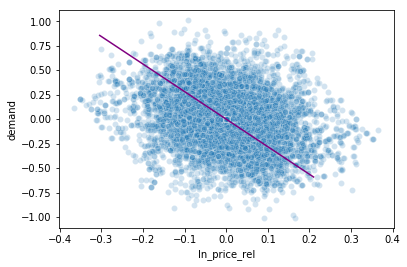

In [109]:
reg_data_df['demand'] = reg_data_df['ln_price_rel']*beta_d_hat
sns.scatterplot(x ='ln_price_rel', y = 'ln_load_rel', alpha = 0.2, data = reg_data_df)
sns.lineplot(x ='ln_price_rel', y = 'demand', color = 'purple', data = reg_data_df.sample(n=100))

In [110]:
-beta_d_hat

2.8131668333823043

### Schwarz et al.

In [1379]:
# Subset dataframe for relevant variables
em_sample_df = data_df.copy()
em_sample_df = df_drop_na(em_sample_df, ['coal_cost'])

# Drop outliers
em_sample_df = drop_outliers(em_sample_df, columns = ['price', 'load'])

In [1380]:
em_sample_df['ln_E_ym']    = np.log(em_sample_df['load'])
em_sample_df['ln_P_ym']    = np.log(em_sample_df['price'])

em_sample_df['ln_E_ym_gm'] = np.mean(em_sample_df['ln_E_ym'])
em_sample_df['ln_P_ym_gm'] = np.mean(em_sample_df['ln_P_ym'])

em_sample_df['E'] = em_sample_df['ln_E_ym'] - em_sample_df['ln_E_ym_gm']
em_sample_df['P'] = em_sample_df['ln_P_ym'] - em_sample_df['ln_P_ym_gm']

em_sample_df['exp_m'] = em_sample_df['price']*em_sample_df['load']
em_sample_df['temp']  = em_sample_df.groupby(['year'])['exp_m'].transform('sum')
em_sample_df['w_ym']  = np.divide(em_sample_df['price']*em_sample_df['load'],
                                 em_sample_df['temp'])
em_sample_df['w_ym_am'] = em_sample_df.groupby(['year'])['w_ym'].transform('mean')
em_sample_df['temp']    = np.multiply(em_sample_df['w_ym'] + em_sample_df['w_ym_am'],
                                      em_sample_df['P'])
em_sample_df['D'] = (1/2)*em_sample_df.groupby(['year'])['temp'].transform('sum')

In [1381]:
smf.ols('E ~ C(state) + np.log(CDD+1) + np.log(HDD+1) + np.add(D, -P) + np.multiply(D, -1)',
       data = em_sample_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     430.6
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:56:35   Log-Likelihood:                 251.94
No. Observations:                 900   AIC:                            -397.9
Df Residuals:                     847   BIC:                            -143.3
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5582      0.057      9.738      0.000       0.446       0.671
C(state)[T.alaska]            -2.1496      0.099    -21.675      0.000      -2.344      -1.955
C(state)[T.arizona]            0.0252      0.056      0.447      0.655      -0.085       0.136
C(state)[T.arkansas]          -0.6890      0.061    -11.246      0.000      -0.809      -0.569
C(state)[T.california]         1.2491      0.076     16.339      0.000       1.099       1.399
C(state)[T.colorado]          -0.6172      0.057    -10.817      0.000      -0.729      -0.505
C(state)[T.connecticut]       -0.5427      0.089     -6.067      0.000      -0.718      -0.367
C(state)[T.delaware]          -1.7942      0.059    -30.342      0.000      -1.910      -1.678
C(state)[T.florida]            1.1122      0.074     14.984      0.000       0.967       1.258
C(state)[T.georgia]            0.6079      0.055     11.015      0.000       0.500       0.716
C(state)[T.idaho]             -1.5409      0.066    -23.398      0.000      -1.670      -1.412
C(state)[T.illinois]           0.3760      0.056      6.729      0.000       0.266       0.486
C(state)[T.indiana]            0.0546      0.057      0.956      0.339      -0.058       0.167
C(state)[T.iowa]              -0.7413      0.059    -12.625      0.000      -0.857      -0.626
C(state)[T.kansas]            -0.8127      0.056    -14.508      0.000      -0.923      -0.703
C(state)[T.kentucky]          -0.2483      0.063     -3.941      0.000      -0.372      -0.125
C(state)[T.louisiana]         -0.2019      0.069     -2.912      0.004      -0.338      -0.066
C(state)[T.maine]             -1.7748      0.072    -24.611      0.000      -1.916      -1.633
C(state)[T.maryland]          -0.0060      0.062     -0.097      0.923      -0.128       0.116
C(state)[T.massachusetts]     -0.2384      0.081     -2.960      0.003      -0.397      -0.080
C(state)[T.michigan]           0.1892      0.063      3.024      0.003       0.066       0.312
C(state)[T.minnesota]         -0.3372      0.065     -5.223      0.000      -0.464      -0.210
C(state)[T.mississippi]       -0.5757      0.057    -10.093      0.000      -0.688      -0.464
C(state)[T.missouri]           0.0870      0.060      1.462      0.144      -0.030       0.204
C(state)[T.montana]           -2.0218      0.058    -34.860      0.000      -2.136      -1.908
C(state)[T.nebraska]          -1.2754      0.065    -19.720      0.000      -1.402      -1.148
C(state)[T.nevada]            -0.9222      0.064    -14.391      0.000      -1.048      -0.796
C(state)[T.new hampshire]     -1.6273      0.080    -20.344      0.000      -1.784      -1.470
C(state)[T.new jersey]         0.1095      0.068      1.613      0.107      -0.024       0.243
C(state)[T.new mexico]        -1.5464      

In [1382]:
em_sample_df['reg_1'] = np.add(em_sample_df['D'], -em_sample_df['P'])
em_sample_df['reg_2'] = -em_sample_df['D']
em_sample_df['date_fmt'] = em_sample_df.apply(lambda x: str(x.month) + '/' + str(x.year), axis = 1)
em_sample_df.to_csv('../data/processed/ces_monthly_s.csv')

### Nonlinear Control IV

In [157]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [160]:
samples = 1000
reg_data_sample_df = reg_data_df.sample(n=samples)

In [161]:
t  = np.array(reg_data_sample_df[['time_diff', 'CDD_1', 'CDD_2', 'HDD_1', 'HDD_2']])
w  = np.array(reg_data_sample_df['ln_coal_rel'])
p  = np.array(reg_data_sample_df['ln_price_rel'])
q  = np.array(reg_data_sample_df['ln_load_rel'])
tw = np.concatenate((t,w.reshape(-1,1)), axis = 1)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='ccccc', 
                              bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='ccccc', 
                             bw=bw_silverman(t)).fit(t)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w)]).fit(w)

# Estimation of CE(P | T, W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[tw], reg_type='lc', var_type='cccccc', 
                             bw=bw_silverman(tw)).fit(tw)

In [162]:
reg_data_sample_df['ce_q_t']  = ce_q_t
reg_data_sample_df['ce_p_t']  = ce_p_t
reg_data_sample_df['ce_p_w']  = ce_p_w
reg_data_sample_df['ce_p_tw'] = ce_p_tw

In [168]:
fit = smf.ols('np.add(ln_load_rel, -ce_q_t) ~ np.add(ce_p_tw, -ce_p_t)', 
              data = reg_data_sample_df
             ).fit(cov_type = 'HC1')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.add(ln_load_rel, -ce_q_t)   R-squared:                       0.013
Model:                                      OLS   Adj. R-squared:                  0.012
Method:                           Least Squares   F-statistic:                     6.823
Date:                          Mon, 08 Apr 2019   Prob (F-statistic):            0.00913
Time:                                  16:16:29   Log-Likelihood:                 835.18
No. Observations:                          1000   AIC:                            -1666.
Df Residuals:                               998   BIC:                            -1657.
Df Model:                                     1                                         
Covariance Type:                            HC1                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0009      0.003     -0.262      0.793      -0.007       0.006
np.add(ce_p_tw, -ce_p_t)    -0.3967      0.152     -2.612      0.009      -0.694      -0.099
==============================================================================
Omnibus:                       83.159   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.707
Skew:                          -0.117   Prob(JB):                     4.02e-95
Kurtosis:                       6.221   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [150]:
# Estimation of f(T)
ce_f_t, _ = nparam.KernelReg(endog=[q - p*fit.params[1]], exog=[t], reg_type='lc', var_type='ccccc', 
                             bw=bw_silverman(t)).fit(t)

# Stderr on beta
reg_data_sample_df['1'] = 1
reg_data_sample_df['X'] = reg_data_sample_df['ce_p_tw'] - reg_data_sample_df['ce_p_t']
S_xx = np.dot(np.array(reg_data_sample_df[['1', 'X']]).T, np.array(reg_data_sample_df[['1', 'X']]))
beta_std = np.var(fit.predict()-ce_f_t) * (np.linalg.inv(S_xx))

In [151]:
beta_std

array([[9.17948967e-06, 1.69285302e-06],
       [1.69285302e-06, 8.08569981e-03]])

In [152]:
-0.4907/(np.diag(beta_std)[1])

-60.68738779662997